In [46]:
try: 
    import cv2
    import torch
    import torchvision
    import sklearn.svm
except:
    %pip install opencv-python-headless==4.9.0.80
    %pip install torch
    %pip install torchvision
    %pip install torchsummary 

import torch
from torch.utils.data import Dataset
from torch import cuda
from torchvision import transforms, datasets, models
import torch.optim as optim
import torch.nn as nn
from torch.optim import lr_scheduler

from pathlib import Path
from timeit import default_timer as timer
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import Counter

from skimage.feature import hog
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV, KFold, train_test_split, cross_val_score, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.model_selection import RandomizedSearchCV

import random
import numpy as np
import time
import copy
import pickle 
import re
import shutil

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

from torchsummary import summary
from PIL import Image

np.set_printoptions(threshold=np.inf)
print('import successful')

import successful


### Remove Jupyter Checkpoints

In [47]:
# remove checkpoints
checkpoints = list(Path('/home/jovyan/work').rglob('.ipynb_checkpoints'))

for file in checkpoints:
    if file.is_dir():        
        for sub_file in file.iterdir():
            if sub_file.is_file():
                sub_file.unlink()
            elif sub_file.is_dir():
                sub_file.rmdir()
    file.rmdir()

print('done')

done


### Init Data Path & Parameters

In [48]:
# Dataset Parameters
DATA_PATH = Path('/home/jovyan/work/data/out/NIMH-CHEFS')

# Dataset-specific paths
LABELS = [f.name for f in DATA_PATH.iterdir() if f.is_dir()]
IMAGE_PATHS = list(DATA_PATH.rglob('*.jpg'))

# Constants for splitting dataset
TRAIN = 'train'
TEST = 'test'
VAL = 'val'

# Model parameters
MODEL_PATH = Path('/home/jovyan/work/models')
BATCH_SIZE = 16
SUBSET_RATIO = 0.1
SUBSET = False

# Constants for feature extraction
FEATURES = 'feature-extraction'
TRANSFER = 'transfer-learning'
FINETUNE = 'fine-tuning'

# Cuda parameters
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
torch.cuda.get_device_name(0)

'NVIDIA RTX 5000 Ada Generation'

### Dataset Class

In [49]:
class Dataset(Dataset):
    def __init__(self, data_path, img_size, transforms=None, phase='train'):
        self.data_path = Path(data_path) / phase
        self.img_size = img_size
        self.transform = transforms[phase]
        self.phase = phase

        self.classes = self._get_classes()
        self.image_paths = self._get_image_paths()
        self.num_classes = len(self.classes)

        self.class_to_int = {class_name: idx for idx, class_name in enumerate(self.classes)}
        self.int_to_class = {idx: class_name for class_name, idx in self.class_to_int.items()}

    def _get_classes(self):
        return [f.name for f in self.data_path.iterdir() if f.is_dir()]

    def _get_image_paths(self):
        paths = list(self.data_path.rglob('*.jpg'))
        random.shuffle(paths)
        return paths

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx])
        img_path = self.image_paths[idx]

        if self.transform:
            img = self.transform(img)

        label = Path(img_path).parent.name
        label = self.class_to_int[label]  # Convert label to integer

        return img, label

    def show_samples(self):
        fig = plt.figure(figsize=(20, 20))

        for i in range(10):
            ax = fig.add_subplot(1, 10, i + 1)
            _, label = self.__getitem__(i)
            img_cv2 = self.get_cv2_img(i)

            ax.imshow(img_cv2, cmap='gray')
            ax.set_title(self.int_to_class[label])  # Show class name instead of index
            ax.axis('off')
        plt.show()

    def show_distribution(self):
        labels_count = Counter([self.__getitem__(i)[1] for i in range(len(self.image_paths))])
        sorted_counts = sorted(labels_count.items())
        labels, counts = zip(*sorted_counts)

        plt.figure(figsize=(10, 3))
        bars = plt.bar(labels, counts, color='skyblue')
        plt.xlabel('Class')
        plt.ylabel('Count')
        plt.title('Counts per Class')
        plt.xticks(rotation=45, ha='right')
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        for bar, count in zip(bars, counts):
            plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, count,
                    ha='center', va='bottom', color='black', fontsize=8)

        plt.tight_layout()
        plt.show()

    def get_cv2_img(self, idx):
        img_path = self.image_paths[idx]
        return cv2.imread(str(img_path))

    def idx_to_class(self, idx_list):
        return [self.int_to_class[idx] for idx in idx_list]

    def class_to_idx(self, class_list):
        return [self.class_to_int[class_name] for class_name in class_list]

    def print_info(self):
        print(f"[INFO] Total number of images: {len(self)}")
        print("[INFO] Number of classes:", self.num_classes)
        print("[INFO] Classes:", self.classes)

In [50]:
data_transforms = {
    TRAIN: transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    VAL: transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]),
    TEST: transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ])
}

In [51]:
datasets = { x: Dataset(DATA_PATH, img_size=224, transforms=data_transforms, phase=x) for x in [TRAIN, VAL, TEST] }
dataloaders = { x: torch.utils.data.DataLoader(datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=4) for x in [TRAIN, VAL, TEST] }
dataset_sizes = { x : len(datasets[x]) for x in [TRAIN, VAL, TEST] }
n_classes = datasets[TRAIN].num_classes

### Init VGG16 for Feature Extraction

In [52]:
# init the VGG model
vgg16 = models.vgg16(weights='IMAGENET1K_V1')
vgg16 = vgg16.to(DEVICE)

# freeze parameters for feature extraction
for param in vgg16.features.parameters():
    param.require_grad = False

# remove classifer to output features
vgg16.classifier = torch.nn.Identity()
vgg16.classifier = vgg16.classifier.to(DEVICE)

### Extract features

In [53]:
# this is the feature extraction method
def extract_features(loader, conv_base):
    conv_base.eval()
    features = []
    labels = []

    with torch.no_grad():
        for (images, targets) in loader:
            # move data to cuda
            images = images.to(DEVICE)
            targets = torch.as_tensor(targets).to(DEVICE)
            
            # Extract features using conv_base
            features_batch = conv_base(images)
            features.append(features_batch.cpu().numpy())
            labels.append(targets.cpu().numpy())

    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    return features, labels

In [54]:
since = time.time()

# extract features
train_features, train_labels = extract_features(loader=dataloaders[TRAIN], conv_base=vgg16)
test_features, test_labels = extract_features(loader=dataloaders[TEST], conv_base=vgg16)
val_features, val_labels = extract_features(loader=dataloaders[VAL], conv_base=vgg16)

elapsed_time = time.time() - since
print(f"Feature Extraction completed in {elapsed_time // 60:.0f}m {elapsed_time % 60:.0f}s")

# combine into one dataset
features = np.concatenate((train_features, test_features, val_features))
labels = np.concatenate((train_labels, test_labels, val_labels))

print(features.shape, labels.shape)

Feature Extraction completed in 0m 2s
(522, 25088) (522,)


### Create Subsamples of Dataset

In [55]:
def stratified_subset(features, labels, ratio):
    num_samples = len(features)
    new_size = int(num_samples * ratio)
    
    sss = StratifiedShuffleSplit(n_splits=1, test_size=new_size, random_state=0)
    for train_index, subset_index in sss.split(features, labels):
        subset_features = features[subset_index]
        subset_labels = labels[subset_index]

    print(subset_features.shape, subset_labels.shape)
    return subset_features, subset_labels


def show_distribution(labels, dataset_name, dataset_ratio):
    unique_values, counts = np.unique(labels, return_counts=True)
    
    plt.figure(figsize=(5, 3))
    bars = plt.bar(unique_values, counts, color='skyblue')
    
    for bar, count in zip(bars, counts):
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.05, count, ha='center', va='bottom')
    
    plt.xlabel('Unique Values')
    plt.ylabel('Counts')
    plt.title(f'Distribution of Unique Values {dataset_name}')
    plt.xticks(unique_values)

    Path('/home/jovyan/work/distributions').mkdir(parents=True, exist_ok=True)
    save_path = f'/home/jovyan/work/distributions/distribution_{dataset_name}_{dataset_ratio}.jpg'

    plt.savefig(save_path)
    plt.show()

(52, 25088) (52,)


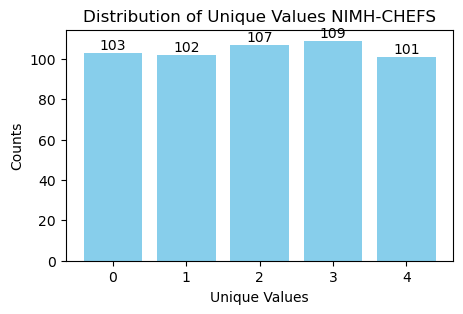

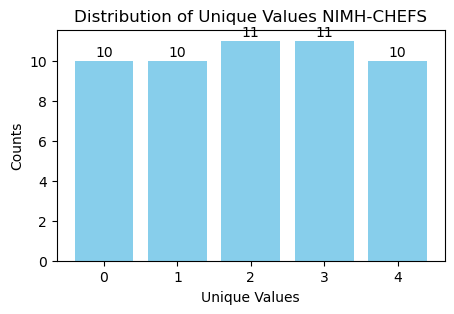

In [56]:
subset_features, subset_labels = stratified_subset(features, labels, SUBSET_RATIO)
show_distribution(labels, 'NIMH-CHEFS', '1.0')
show_distribution(subset_labels, 'NIMH-CHEFS', '0.1')

In [57]:
def print_score(clf, x_train, y_train, x_test, y_test, mode, train=True):
    if train:
        y_prediction = clf.predict(x_train)
        clf_report = classification_report(y_train, y_prediction)
        train_result = (
            "Train Result:\n"
            "================================================\n"
            f"Accuracy Score: {accuracy_score(y_train, y_prediction) * 100:.2f}%\n"
            "_______________________________________________\n"
            f"CLASSIFICATION REPORT:\n{clf_report}\n"
            "_______________________________________________\n"
            f"Confusion Matrix: \n {confusion_matrix(y_train, y_prediction)}\n\n"
        )
        Path('/home/jovyan/work/reports').mkdir(parents=True, exist_ok=True)
        (Path(f'/home/jovyan/work/reports/training_results_{mode}.txt')).write_text(train_result)

        print(train_result)
        
    elif train==False:
        y_prediction = clf.predict(x_test)
        clf_report = classification_report(y_test, y_prediction)
        test_result = (
            "Test Result:\n"
            "================================================\n"
            f"Accuracy Score: {accuracy_score(y_test, y_prediction) * 100:.2f}%\n"
            "_______________________________________________\n"
            f"CLASSIFICATION REPORT:\n{clf_report}\n"
            "_______________________________________________\n"
            f"Confusion Matrix: \n {confusion_matrix(y_test, y_prediction)}\n\n"
        )
        Path('/home/jovyan/work/reports').mkdir(parents=True, exist_ok=True)
        (Path(f'/home/jovyan/work/reports/test_results_{mode}.txt')).write_text(test_result)

        print(test_result)

#### SVM Init

In [58]:
if SUBSET:
    x_train, x_test, y_train, y_test = train_test_split(subset_features, subset_labels, test_size=0.2, shuffle=True, stratify=subset_labels, random_state=42)
else: 
    x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, shuffle=True, stratify=labels, random_state=42)

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(417, 25088) (105, 25088) (417,) (105,)


In [61]:

param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf', 'poly', 'sigmoid'],
    'degree': [2, 3, 4]
}

"""
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf'],
}
"""
"""
grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=3, cv=5)
grid.fit(x_train, y_train)
print("Best Parameters:", grid.best_params_)
best_model = grid.best_estimator_
y_pred = best_model.predict(x_test)
"""

halving_random_search = HalvingRandomSearchCV(SVC(), param_grid, n_candidates='exhaust', refit=True, verbose=3, cv=5, factor=2, random_state=42)
halving_random_search.fit(x_train, y_train)
print("Best Parameters:", halving_random_search.best_params_)
best_model = halving_random_search.best_estimator_
y_pred = best_model.predict(x_test)

"""
random_search = RandomizedSearchCV(SVC(), param_grid, n_iter=10, refit=True, verbose=3, cv=5, random_state=42)
random_search.fit(x_train, y_train)
print("Best Parameters:", random_search.best_params_)
best_model = random_search.best_estimator_
y_pred = best_model.predict(x_test)
"""

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 50
max_resources_: 417
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 8
n_resources: 50
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END C=0.1, degree=2, gamma=0.001, kernel=rbf;, score=(train=0.231, test=0.200) total time=   0.1s
[CV 2/5] END C=0.1, degree=2, gamma=0.001, kernel=rbf;, score=(train=0.256, test=0.300) total time=   0.1s
[CV 3/5] END C=0.1, degree=2, gamma=0.001, kernel=rbf;, score=(train=0.300, test=0.222) total time=   0.0s
[CV 4/5] END C=0.1, degree=2, gamma=0.001, kernel=rbf;, score=(train=0.300, test=0.333) total time=   0.0s
[CV 5/5] END C=0.1, degree=2, gamma=0.001, kernel=rbf;, score=(train=0.325, test=0.222) total time=   0.0s
[CV 1/5] END C=1000, degree=2, gamma=0.1, kernel=poly;, score=(train=1.000, test=0.600) total time=   0.0s
[CV 2/5] END C=1000, degree=2, gamma=0.1, kernel=poly;, score=(train=1.000, test=0.700) total time=   

'\nrandom_search = RandomizedSearchCV(SVC(), param_grid, n_iter=10, refit=True, verbose=3, cv=5, random_state=42)\nrandom_search.fit(x_train, y_train)\nprint("Best Parameters:", random_search.best_params_)\nbest_model = random_search.best_estimator_\ny_pred = best_model.predict(x_test)\n'

In [60]:
print_score(best_model, x_train, y_train, x_test, y_test, mode='SVM_NIMH-CHEFS', train=False)

Test Result:
Accuracy Score: 66.67%
_______________________________________________
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       1.00      0.57      0.73        21
           1       0.52      0.75      0.61        20
           2       0.90      0.82      0.86        22
           3       0.54      0.64      0.58        22
           4       0.61      0.55      0.58        20

    accuracy                           0.67       105
   macro avg       0.71      0.67      0.67       105
weighted avg       0.72      0.67      0.67       105

_______________________________________________
Confusion Matrix: 
 [[12  3  1  5  0]
 [ 0 15  0  2  3]
 [ 0  2 18  1  1]
 [ 0  4  1 14  3]
 [ 0  5  0  4 11]]




#### Export to ONNX

In [42]:
%pip install onnx skl2onnx

import onnx
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

print('import successful')

Note: you may need to restart the kernel to use updated packages.
import successful


In [ ]:
initial_type = [('float_input', FloatTensorType([None, x_train.shape[1]]))]
onnx_model = convert_sklearn(best_model, initial_types=initial_type)

# Save the model to a file
with open("best_model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [17]:
since = time.time()

classifier = SVC(C=0.1, gamma=1, kernel='rbf')
classifier.fit(x_train, y_train)

elapsed_time = time.time() - since
print(f"Training SVM completed in {elapsed_time // 60:.0f}m {elapsed_time % 60:.0f}s")

print_score(classifier, x_train, y_train, x_test, y_test, mode='SVM_NIMH-CHEFS', train=False)

Training SVM completed in 0m 3s
Test Result:
Accuracy Score: 20.95%
_______________________________________________
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        21
           1       0.00      0.00      0.00        20
           2       0.00      0.00      0.00        22
           3       0.21      1.00      0.35        22
           4       0.00      0.00      0.00        20

    accuracy                           0.21       105
   macro avg       0.04      0.20      0.07       105
weighted avg       0.04      0.21      0.07       105

_______________________________________________
Confusion Matrix: 
 [[ 0  0  0 21  0]
 [ 0  0  0 20  0]
 [ 0  0  0 22  0]
 [ 0  0  0 22  0]
 [ 0  0  0 20  0]]




/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
#print_score(classifier, x_train, y_train, x_test, y_test, mode='SVM_NIMH-CHEFS', train=True)


In [ ]:
print_score(classifier, x_train, y_train, x_test, y_test, mode='SVM_NIMH-CHEFS', train=False)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred = classifier.predict(x_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(accuracy, precision, recall, f1)